In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.model_selection import train_test_split

In [2]:
def sampling(x, num):
    l, r = -1, 1 #左区间、右区间
    for i in range(num):
        rand_num = random.random() # 生成[0,1]之间的随机数
        mapped_num = (r - l) * rand_num + l
        x.append(mapped_num)

In [3]:
np.random.seed(77)
numbers = 100
x_regression = []
sampling(x_regression, numbers)
x_classification = []
sampling(x_classification, numbers)
len(x_regression), len(x_classification)

(100, 100)

In [4]:
#定义噪声
def noise(mu, sigma, num):
    return np.random.normal(mu, sigma, num)
#定义sign函数
def sgn(x):
    return np.where(x > 0, 1, -1)

In [5]:
x_regression = np.array(x_regression)
x_classification = np.array(x_classification)
y_regression = 0.36*x_regression + 0.65*x_regression**2 + 0.12*x_regression**3 - 0.32 *x_regression**4 + 0.75 * x_regression**5 - 0.54*x_regression**6 + 0.1*noise(0,0.1,numbers) 
y_classification = sgn(0.36*x_classification + 0.65*x_classification**2 + 0.12*x_classification**3 - 0.32 *x_classification**4 + 0.75 * x_classification**5 - 0.54*x_classification**6 + 0.1*noise(0,0.1,numbers)) 

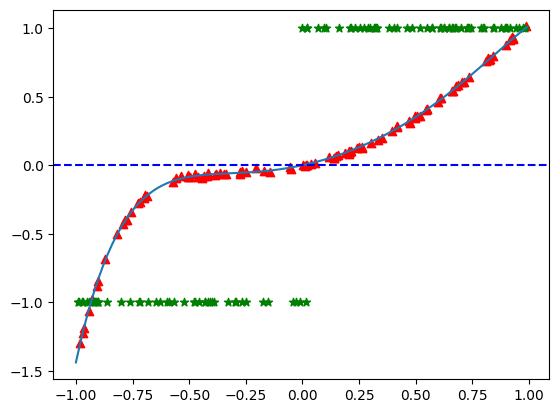

In [6]:
# 创建一个numpy数组x，范围为-10到10，步长为0.1
x = np.arange(-1, 1, 0.01)
y = 0.36*x + 0.65*x**2 + 0.12*x**3 - 0.32 *x**4 + 0.75 * x**5 - 0.54*x**6
plt.plot(x, y)
plt.scatter(x_regression, y_regression, c='r', marker='^')
plt.scatter(x_classification, y_classification, c='g', marker='*')
plt.axhline(y=0, color='b', linestyle='--')

plt.show()

In [10]:
def gaussian_basis(x, mu, sigma):
    return np.exp(-(x-mu)**2 / (2 * sigma**2))

In [11]:
#幂函数映射，高斯函数映射
mu = np.array([-0.75,-0.5,-0.25,0,0.25,0.5,0.75])  # 高斯函数的中心
sigma = 0.1
x_regression_gaussian = gaussian_basis(x_regression.reshape(numbers,1), mu, sigma)
x_classification_gaussian = gaussian_basis(x_classification.reshape(numbers,1), mu, sigma)

In [16]:
x_y_regressiongauss = np.concatenate([x_regression_gaussian,y_regression.reshape(numbers,1)],axis=1)

/home/ubuntu/anaconda3/envs/zhc/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in log


随机梯度下降法SGD最终训练的分类系数：
x1   0.8962453741985078
x2   0.6042405836043905
x3   0.8241383860987429
x4   0.3533324999740232
x5   0.4771256500289865
x6   0.2737644411764035
x7   0.7833377161018681


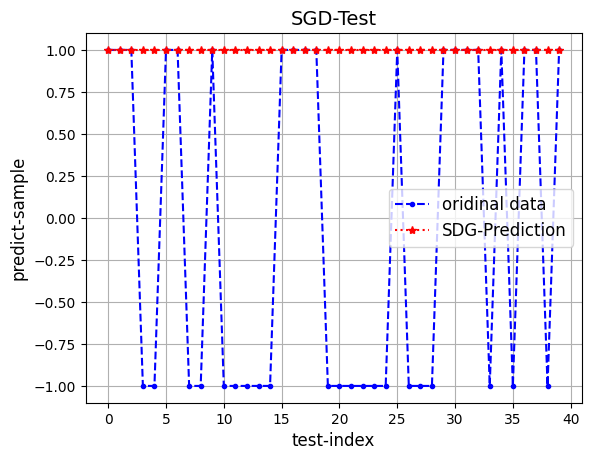

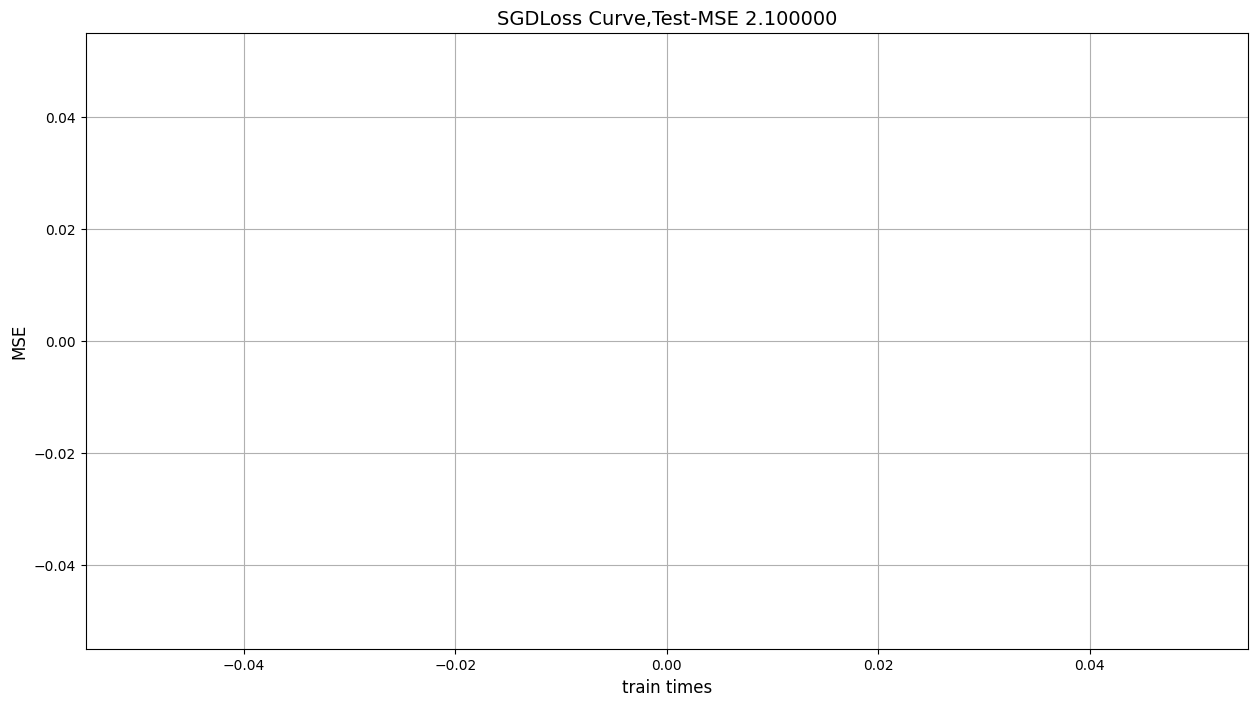

x1   0.8962453741985078
x2   0.6042405836043905
x3   0.8241383860987429
x4   0.3533324999740232
x5   0.4771256500289865
x6   0.2737644411764035
x7   0.7833377161018681
[ 0.04891052  0.39807428  0.08750056  0.41988023 -0.17289201  0.43867887
  0.21077131]
0.04891051699906788
0.3980742826546931
0.08750056033676953
0.4198802251947728
-0.17289200563147453
0.43867887303733555
0.2107713128816318
随机梯度下降法SGD最终训练的回归系数：


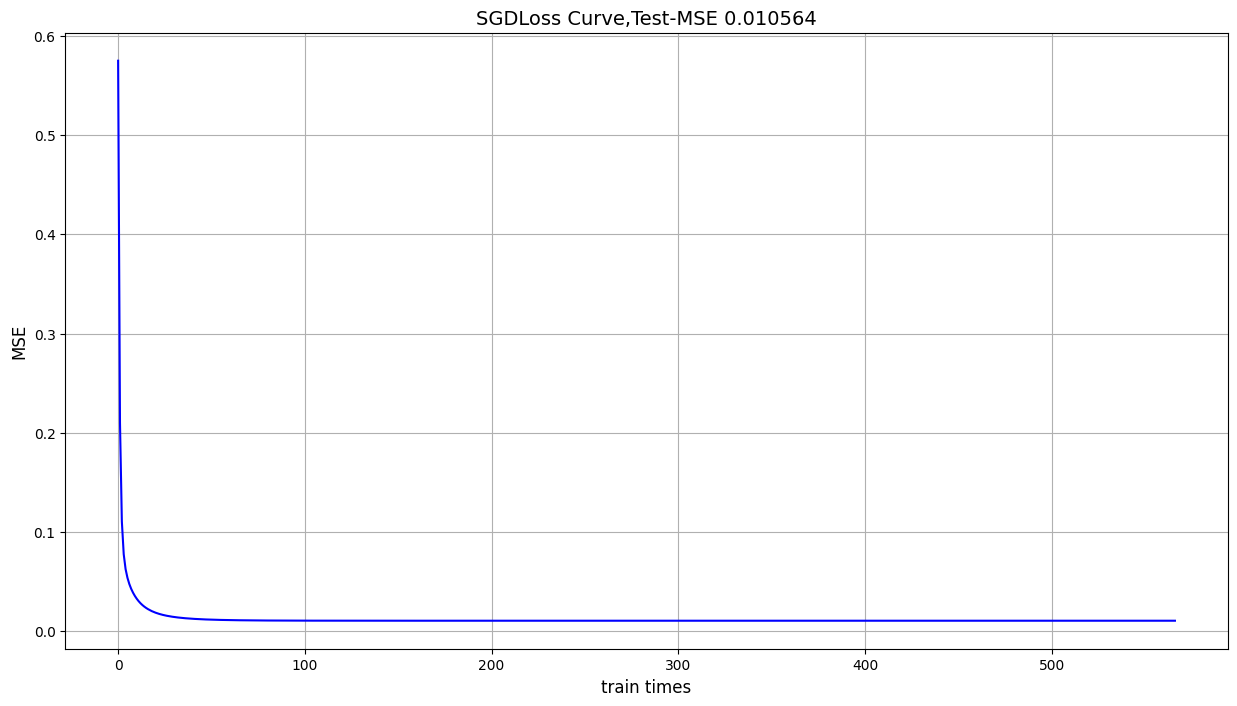

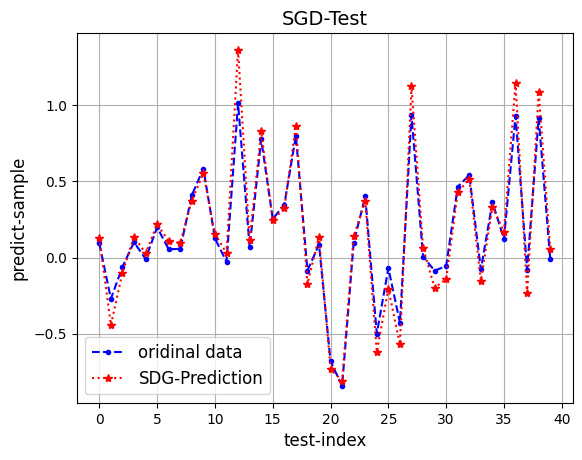

In [26]:
class GD_Linear_Model():
    def __init__(self, data, feature_list, alpha, beta, sigma):
        self.data = pd.DataFrame(data) #读取数据
        
        self.feature_labels = feature_list[:-1] #特征标签
        self.target_label = feature_list[-1] #目标值
        
        self.data_scale = self.data #StandardScaler().fit_transform(self.data) #数据标准化 
        
        self.X = np.array(self.data_scale.iloc[:, :-1])  #取X 
        self.y = np.array(self.data_scale.iloc[:, -1])  #取y

        
        self.x_train, self.x_test, self.y_train, self.y_test = \
            train_test_split(self.X, self.y, train_size=0.6, random_state=42)  #数据集划分
        
        self.alpha = alpha  #步长
        self.beta = beta #正则化因子
        self.sigma = sigma
        self.n, self.k = self.x_train.shape #训练集的大小和特征数量
        
    def sgd_regression_train(self, reweight, loop_max, threshold):
        np.random.seed(77) #设置随机数种子方便复现实验
        weight = reweight  # 使用正态分布随机初始化权重
        alpha_lr = self.alpha  # 用于衰减指数 我们先固定
        beta_lr = self.beta #用于正则化因子
        sigma_lr = self.sigma
        sdg_weight = dict()  # 存储权重更新过程值
        
        for j in range(self.k):
            sdg_weight[str(j)] = []
        train_loss_mean = []  # 存储训练过程中的误差损失
        weight_old = weight
        loop = 0  # 训练迭代变量
        for loop in range(loop_max):  # 外层循环，不断进行迭代
            alpha_lr *= 0.95  # 衰减指数0.95
            index = np.random.permutation(self.n)  # 样本索引号打乱
            train_X = self.x_train[index]  # 打乱训练数据样本
            train_y = self.y_train[index]
            for i in range(self.n):
                z = self.probit(train_X[i], weight)
                y_hat = train_X[i].dot(weight.T)
                weight = weight + alpha_lr * (-beta_lr * (y_hat - train_y[i]) * train_X[i] -  sigma_lr * weight)
            for j in range(self.k):
                sdg_weight[str(j)].append(weight[j])
            # 存储误差损失平方和平均值
            train_loss_mean.append(((train_X.dot(weight.T) - train_y) ** 2).mean()) 
            # 判断相邻两次权重更新变化，当变化小于给定阀值的时候，提前停止训练
            if np.abs(weight - weight_old).all() < threshold:
                break
            else:
                weight_old = weight

                
        print(weight) 
        for j in range(self.k):
                print(sdg_weight[str(j)][-1])
        y_test_hat, loss_test = self.predict(weight)  # 预测
        model_info_dict = self.model_info(loop + 1, train_loss_mean, sdg_weight, y_test_hat, loss_test)
        return model_info_dict
    
    def probit(self, x, w):
        # 计算Probit函数的值
        return norm.cdf(np.dot(x, w))

    def probit_gradient(self, x, w):
        # 计算Probit函数的梯度
        return norm.pdf(np.dot(x, w)) * x
    
    def sgn(self, x):
        return np.where(x > 0, 1, -1)
    
    def sgd_classification_train(self, re_weight, loop_max, threshold):
        np.random.seed(77) #设置随机数种子方便复现实验
        weight = re_weight  # 使用正态分布随机初始化权重
        alpha_lr = self.alpha  # 用于衰减指数 我们先固定
        beta_lr = self.beta #用于正则化因子
        sigma_lr = self.sigma
        sdg_weight = dict()  # 存储权重更新过程值

        for j in range(self.k):
            sdg_weight[str(j)] = []
        train_loss_mean = []  # 存储训练过程中的误差损失
        weight_old = weight
        loop = 0  # 训练迭代变量
        for loop in range(loop_max):  # 外层循环，不断进行迭代
            alpha_lr *= 0.95  # 衰减指数0.95
            index = np.random.permutation(self.n)  # 样本索引号打乱
            train_X = self.x_train[index]  # 打乱训练数据样本
            train_y = self.y_train[index]
            for i in range(self.n):                
                z = self.probit(train_X[i], weight)
                weight = weight + alpha_lr * (self.probit_gradient(train_X[i], weight) * train_y[i] / z - sigma_lr * weight)
            for j in range(self.k):
                sdg_weight[str(j)].append(weight[j])
            # 存储误差损失平方和平均值
            yes_or_no = self.sgn(train_X.dot(weight.T) * train_y)
            if np.any(yes_or_no < 0):
                train_loss_mean.append(np.mean(-np.log(yes_or_no)))
            # 判断相邻两次权重更新变化，当变化小于给定阀值的时候，提前停止训练
            if np.abs(weight - weight_old).all() < threshold:
                break
            else:
                weight_old = weight
        y_test_hat, loss_test = self.predict1(weight)  # 预测
        model_info_dict = self.model_info(loop + 1, train_loss_mean, sdg_weight, y_test_hat, loss_test) 
        return model_info_dict

    def model_info(self, loop, loss_train, weight, y_test_hat, loss_test):
        model_info_dict = dict()
        model_info_dict["loop"] = loop
        model_info_dict["loss_train"] = loss_train
        model_info_dict["weight"] = weight
        model_info_dict["y_test_hat"] = y_test_hat
        model_info_dict["loss_test"] = loss_test
        return model_info_dict

    def predict(self, weight):
        y_test_hat = self.x_test.dot(weight.T)
        loss_test = ((y_test_hat - self.y_test) ** 2).mean()
        return y_test_hat, loss_test
    
    def predict1(self, weight):
#         y_test_hat = self.sgn(self.x_test @ weight.T)
        y_test_hat = np.where(self.probit(self.x_test, weight) > 0.5, 1, -1)
        loss_test = ((y_test_hat - self.y_test) ** 2).mean()
        return y_test_hat, loss_test
    
    def classification_predict(self, weight):
        y_test_hat = self.sgn(self.x_test.dot(weight.T))  # 使用sign函数进行分类
        y_test_hat[y_test_hat == 0] = -1  # 将0标签转换为-1
        accuracy = (y_test_hat == self.y_test).mean()  # 计算分类准确率
        return y_test_hat, accuracy
    def plt_loss_weight(self, sgd_info_dict):
        def plt_loss(info_dict, title):
            plt.plot(info_dict["loss_train"], 'b-')
            plt.xlabel("train times", fontdict={"fontsize": 12})
            plt.ylabel("MSE", fontdict={"fontsize": 12})
            plt.title(title + "Loss Curve,Test-MSE %f" %
                      info_dict["loss_test"], fontdict={"fontsize": 14})
            plt.grid()

        def plt_weight(info_dict, title):
            for j in range(self.k):
                plt.plot(info_dict["weight"][str(j)], label=self.feature_labels[j])
            plt.xlabel("Weight update times", fontdict={"fontsize": 12})
            plt.ylabel("feature-weight", fontdict={"fontsize": 12})
            plt.title(title + "regression-update-curve", fontdict={"fontsize": 14})
            plt.grid()
            plt.legend(fontsize=12)

        plt.figure(figsize=(15, 8))
        plt_loss(sgd_info_dict, "SGD")
#         plt_weight(sgd_info_dict, "SGD")
        plt.show()

    def plt_predict(self, sgd_info_dict):
        # 绘制预测值与真实值对比图 #self.y
        plt.plot(self.y_test, 'b.--', label="oridinal data")
        plt.plot(sgd_info_dict["y_test_hat"], 'r*:', label="SDG-Prediction")
        plt.xlabel("test-index", fontdict={"fontsize": 12})
        plt.ylabel("predict-sample", fontdict={"fontsize": 12})
        plt.title("SGD-Test", fontdict={"fontsize": 14})
        plt.legend(fontsize=12)
        plt.grid()
        plt.show()
        
    def plt_predict1(self, sgd_info_dict):
        # 绘制预测值与真实值对比图 #self.y
        plt.plot(self.y_test, 'b.--', label="oridinal data")
        plt.plot(self.sgn(sgd_info_dict["y_test_hat"]), 'r*:', label="SDG-Prediction")
        plt.xlabel("test-index", fontdict={"fontsize": 12})
        plt.ylabel("predict-sample", fontdict={"fontsize": 12})
        plt.title("SGD-Test", fontdict={"fontsize": 14})
        plt.legend(fontsize=12)
        plt.grid()
        plt.show()

if __name__ == '__main__':
#     attribute_list = ["x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","y"]#["x1","x2","x3","bias","y"]
    attribute_list = ["x1","x2","x3","x4","x5","x6","x7","y"]
    
    alpha = 1e-3
    beta = 10
    sigma = 0.001
    weight = np.random.random(7)  # 使用正态分布随机初始化权重

    data1 = x_y_classification6
    gdlm = GD_Linear_Model(data1, attribute_list, alpha, beta, sigma)
    sgd_info_dict = gdlm.sgd_classification_train(weight, 100, 1e-6)
    print("=" * 70)
    print("随机梯度下降法SGD最终训练的分类系数：")
    for i in range(gdlm.k):
        print(attribute_list[i], " ", sgd_info_dict["weight"][str(i)][-1])
    print("=" * 70)
    gdlm.plt_predict1(sgd_info_dict)
    gdlm.plt_loss_weight(sgd_info_dict)

    weight = []
    for i in range(gdlm.k):
        weight.append(sgd_info_dict["weight"][str(i)][-1]) 
        print(attribute_list[i], " ", sgd_info_dict["weight"][str(i)][-1])
    weight = np.array(weight)
    

    data = x_y_regression6
    gdlm = GD_Linear_Model(data, attribute_list, alpha, beta, sigma)
    sgd_info_dict = gdlm.sgd_regression_train(weight, 1000, 1e-6)
    print("=" * 70)
    print("随机梯度下降法SGD最终训练的回归系数：")
    print("=" * 70)
    gdlm.plt_loss_weight(sgd_info_dict)
    gdlm.plt_predict(sgd_info_dict)

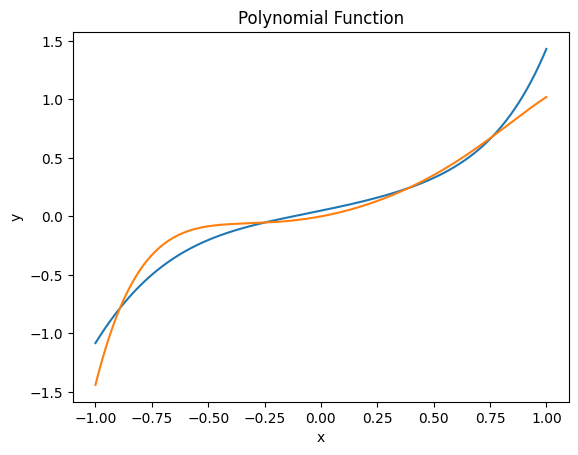

In [27]:
def polynomial(w, x):
#     y = w[0] + w[1]*x + w[2]*x**2 + w[3]*x**3
    y = w[0]*1 + w[1]*x + w[2]*x**2 + w[3]*x**3 + w[4]*x**4 + w[5]*x**5+ w[6]*x**6
    return y

w = [
0.04891051699906788
,0.3980742826546931
,0.08750056033676953
,0.4198802251947728
,-0.17289200563147453
,0.43867887303733555
,0.2107713128816318
]
x = np.linspace(-1, 1, num=1000)  # 生成100个均匀分布的x值
y = polynomial(w, x)  # 计算对应的y值
plt.plot(x, y)
y = 0.36*x + 0.65*x**2 + 0.12*x**3 - 0.32 *x**4 + 0.75 * x**5 - 0.54*x**6
plt.plot(x, y)
# 绘制图像
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Function')
plt.show()

